# Parte opcional - Cimbala

## Gráficos

Graficamos $\frac{X_i - \bar{X}}{S}$ para cada salto en la ruta para ver que pinta tiene

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import taller2
import thomson

import seaborn as sns
import pandas as pd # name a more iconic duo
import matplotlib.pyplot as plt
import statistics
from typing import Tuple

sns.set_style("whitegrid")

In [70]:
def calculate_errors(stats: taller2.Stats, hops: int) -> int:
    # Obtenemos la distribución de dRTTs
    drtts = []
    
    for i, hop in enumerate(stats[:hops+1]):
        if "d_rtt" not in hop:
            continue
        
        drtts.append(hop["d_rtt"])
    
    print(drtts)
        
    # Calculamos la media y el desvio estandar
    media = statistics.mean(drtts)
    sd = statistics.stdev(drtts)
    print(sd, media)

    # Calculamos el error, (x_i - media)/sd
    for i, hop in enumerate(stats[:hops+1]):
        if "d_rtt" not in hop:
            continue

        hop["error"] = (hop["d_rtt"]-media)/sd

    return len(drtts)

def get_df(ip: str, hops: int, dont_remove_first: bool = False) -> Tuple[pd.DataFrame, int]:
    _, stats = taller2.deserialize(ip)
    taller2.extend_with_geo(stats)
    taller2.d_rtt(stats)
    n = calculate_errors(stats, hops)
    
    df = pd.DataFrame(stats)
    df["hop"] = df.index
    if dont_remove_first:
        df["hop"] += 1
        return df, n

    return df[df["hop"] >= 1], n

In [74]:
IP_DELHI = "14.139.45.149"
IP_CMU = "128.2.42.52"
IP_OSAKA = "133.1.138.1"

HOPS_OSAKA = 22
HOPS_DELHI = 15
HOPS_CMU = 15

df_osaka, n_osaka = get_df(IP_OSAKA, HOPS_OSAKA, True)
df_cmu, n_cmu = get_df(IP_CMU, HOPS_CMU)
df_delhi, n_delhi = get_df(IP_DELHI, HOPS_DELHI)

[0.5, 0.8199999999999985, 0.120000000000001, 156.35000000000002, 1.8499999999999943, 18.249999999999996, 114.61000000000001, 16.03, 51.71000000000001, 54.400000000000006, 66.49000000000001, 101.65999999999997, 1.1100000000000136, 1.3199999999999932, 1.509999999999991, 6.899999999999977, 5.550000000000011, 2.3000000000000114, 6.769999999999982]
46.68267809282292 32.01315789473684
[15.341997146606445, 125.01657009124756, 148.8887071609497, 151.36027336120605, 0.36215782165527344, 0.8380413055419922, 0.6911754608154297, 1.0533332824707031]
72.06385503500275 55.444031953811646
[38.05685043334961, 102.0357608795166, 112.06269264221191, 112.14494705200195, 92.07797050476074, 200.09756088256836, 19.458770751953125, 136.46650314331055]
56.078846056097504 101.5501320362091


In [75]:
def plot_errors(ax1, df: pd.DataFrame, hops: int, n: int, name: str):
    ax = sns.scatterplot(ax = ax1, data=df[df["hop"] <= hops], x="hop", y="error", hue="country_name")
    ax.axhline(thomson.get_tabulated_value(n), ls=':', lw=1.5, color="black")
    ax.set(xlabel='Hop', ylabel='error')
    ax.set_title(name)
    ax.set_xticks(range(1,hops+1))

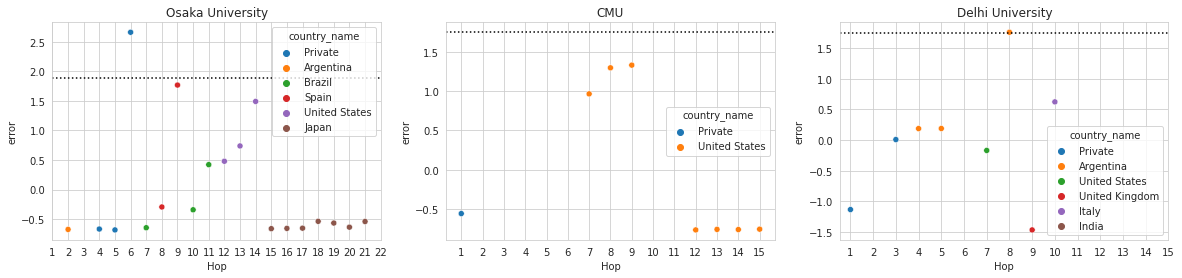

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
plot_errors(ax1, df_osaka, HOPS_OSAKA, n_osaka, "Osaka University")
plot_errors(ax2, df_cmu, HOPS_CMU, 8, "CMU")
plot_errors(ax3, df_delhi, HOPS_DELHI, n_delhi, "Delhi University")
plt.savefig("img/cimbala-init-errors.svg")

In [50]:
def thomson_outlier_detection(ip: str, name: str, hops: int, skip_first: bool, hardcoded_t: int = None):
    _, stats = taller2.deserialize(ip)
    taller2.d_rtt(stats)
    taller2.extend_with_geo(stats)
    stats = stats[:hops+1]
    for i in range(len(stats)):
        stats[i]["hop"] = i
        if not skip_first:
            stats[i]["hop"] += 1


    # Obtenemos la distribución de dRTTs y filtramos por los que no tienen dRTT
    stats = list(filter(lambda d: "d_rtt" in d, stats))
    while len(stats) != 0:
        drtts = list(map(lambda d: d["d_rtt"], stats))

        t = hardcoded_t
        if t is None:
            t = thomson.get_tabulated_value(len(drtts))

        # Calculamos la media y el desvio estandar
        media = statistics.mean(drtts)
        sd = statistics.stdev(drtts)

        # Tomamos como outlier si (x_i - media) > t * sd
        before = len(stats)
        for i, hop in enumerate(stats):
            print(f"[{hop['hop']}] media: {media}, drtt: {hop['d_rtt']}, sd: {sd}, t: {t}")
            hop["delta"] = abs(hop["d_rtt"]-media)
        
        stats.sort(key=lambda d: d["delta"], reverse=True) # desc
        hop = stats[0]
        delta = hop["delta"]
        if delta > t * sd:
            meta = ""
            if "org" in hop:
                meta = f"{hop['city']} - {hop['country_name']}"
            print(f"[{ip} ({name})] El hop #{hop['hop']} con ip {hop['IP']} ({meta}) es un outlier (delta={delta:.2f})")
            del stats[0]
        else:
            break

In [51]:
ips = [
    #(IP_DELHI, "Delhi", HOPS_DELHI, True),
    (IP_CMU, "CMU", HOPS_CMU, True),
    #(IP_OSAKA, "Osaka", HOPS_OSAKA, False),
]

for ip, name, hops, skip in ips:
    thomson_outlier_detection(ip, name, hops, skip)

[1] media: 55.444031953811646, drtt: 15.341997146606445, sd: 72.06385503500275, t: 1.7491
[7] media: 55.444031953811646, drtt: 125.01657009124756, sd: 72.06385503500275, t: 1.7491
[8] media: 55.444031953811646, drtt: 148.8887071609497, sd: 72.06385503500275, t: 1.7491
[9] media: 55.444031953811646, drtt: 151.36027336120605, sd: 72.06385503500275, t: 1.7491
[12] media: 55.444031953811646, drtt: 0.36215782165527344, sd: 72.06385503500275, t: 1.7491
[13] media: 55.444031953811646, drtt: 0.8380413055419922, sd: 72.06385503500275, t: 1.7491
[14] media: 55.444031953811646, drtt: 0.6911754608154297, sd: 72.06385503500275, t: 1.7491
[15] media: 55.444031953811646, drtt: 1.0533332824707031, sd: 72.06385503500275, t: 1.7491


In [37]:
df_osaka

,IP,median,sd,country_name,city,org,lat,long,d_rtt,error,hop
0,192.168.1.1,17.17,7.37,Private,Private,Private,NaN,NaN,NaN,NaN,1
1,200.51.241.181,14.76,13.55,Argentina,Buenos Aires,AS10834 Telefonica de Argentina,-34.6131,-58.3772,0.50,-0.675050,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,10.192.19.58,15.26,1.57,Private,Private,Private,NaN,NaN,0.82,-0.668196,4
4,10.192.19.52,16.08,1.15,Private,Private,Private,NaN,NaN,0.12,-0.683190,5
5,10.192.18.12,16.20,2.08,Private,Private,Private,NaN,NaN,156.35,2.663447,6
6,94.142.98.192,172.55,5.33,Brazil,São Paulo,AS12956 TELEFONICA GLOBAL SOLUTIONS SL,-23.5475,-46.6361,1.85,-0.646132,7
7,213.140.39.116,25.51,40.84,Spain,Madrid,AS12956 TELEFONICA GLOBAL SOLUTIONS SL,40.4165,-3.7026,18.25,-0.294824,8
8,176.52.249.39,43.76,3.28,Spain,Madrid,AS12956 TELEFONICA GLOBAL SOLUTIONS SL,40.4165,-3.7026,114.61,1.769325,9
9,94.142.98.123,158.37,0.00,Brazil,São Paulo,AS12956 TELEFONICA GLOBAL SOLUTIONS SL,-23.5475,-46.6361,16.03,-0.342379,10
